<a href="https://colab.research.google.com/github/Chigaga/area_calculation/blob/main/area_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries

In [ ]:
!pip install sunpy

Import necessary modules and a sample map for testing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

import sunpy.map
from sunpy.data.sample import AIA_171_IMAGE
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk

import astropy.units as u
from astropy.coordinates import SkyCoord

from PIL import Image
from math import asin, sqrt, pi

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

AIA20110607_063302_0171_lowres.fits:   0%|          | 0.00/973k [00:00<?, ?B/s]

In [16]:
# create a map
aia_map = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)

# define a pixel for test
pixel_coord = (700, 600)

# define a rectangle region for test
xlim = [600,800]
ylim = [550,650]

# list of the coordinates within a test region (this can be area of any shape)
region_coords = [(x, y) for x in range(xlim[0], xlim[1] + 1) for y in range(ylim[0], ylim[1] + 1)]

Plotting:

*   Map
*   Chosen area
*   Chosen pixel



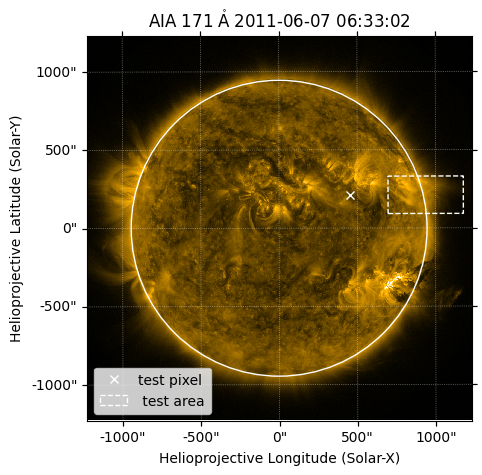

In [14]:
#@title Code for plotting { display-mode: "form" }

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection=aia_map)
aia_map.plot(axes=ax, clip_interval=(1, 99.99)*u.percent)

#drawing the boundaries of the solar disk
aia_map.draw_limb(color='white')

# plotting the chosen pixel
ax.plot(pixel_coord[0]* u.pix, pixel_coord[1]* u.pix, 'x', color='white',
        label=f'test pixel')

#plotting the area
bottom_left = aia_map.pixel_to_world(xlim[0] * u.pixel, ylim[0] * u.pixel)
top_right = aia_map.pixel_to_world(xlim[1] * u.pixel, ylim[1] * u.pixel)

aia_map.draw_quadrangle(
    bottom_left,
    axes=ax,
    top_right=top_right,
    edgecolor="white",
    linestyle="--",
    linewidth=1,
    label=' test area'
)

ax.legend(loc='lower left')

In [6]:
#@title Functions for area calculation { display-mode: "form" }
def rad_parallel_cut(rad):
    """
    Computes the radiuses of circles at the Sun parallels given a radius in pixels.

    Args:
    rad (int): The radius in pixels.

    Returns:
    numpy.ndarray: An array containing the computed radiuses of circles.
    """
    out = np.zeros(2 * rad + 1)
    for it in range(0, rad + 1):
        out[it] = int(np.sqrt((rad ** 2 - (rad - it) ** 2)))
    out[rad + 1 : 2 * rad + 1] = np.flipud(out[0 : rad])
    return out


def map_info(smap):
    """
    Extracts information from the Sunpy map.

    Args:
        smap (SunpyMap): Solar map object containing metadata.

    Returns:
        tuple: A tuple containing the following information:
            - rad (int): Sun radius in pixels.
            - R_km (float): Sun radius in kilometers.
            - cenX (int): X-axis reference pixel converted for Python
            - cenY (int): Y-axis reference pixel converted for Python
            - nanleft (numpy.ndarray): Distance from the left (grid start)
            - dist_top (int): Distance from the top (grid start) to the solar disk
    """

    meta = smap.meta

    rad = int(meta['rsun_obs'] / meta['cdelt1'])
    R_km = meta['rsun_ref'] * 10 ** (-3)

    # Note that CRPIXn follows the Fortran convention of counting from 1 to N,
    #instead of from 0 to N − 1 as is done in some programming languages. Thus we put -1 to its value
    cenX = int(meta['crpix1'])-1
    cenY = int(meta['crpix2'])-1

    nanleft = np.array(cenX - rad_parallel_cut(rad))
    dist_top = cenY - rad

    return rad, R_km, cenX, cenY, nanleft, dist_top




def calculate_integral(pixel_coords, rad, R_km, cenX, cenY, nanleft, dist_top):
    """
    Calculate the area of single pixel using surface integral based on the given pixel coordinates.
    The area of surface A that has the projection on the circle S (1 pixel) is calculated using the double integral over surface:
    A=IntegralIntegral(sqrt(1+(dz/dx)**2+(dz/dy)**2))dxdy), where y=i, x=j, x^2+y^2+z^2=R^2,
    i starts from the top of disk, j starts from the left part of disk

    Args:
        - pixel_coords (tuple): Tuple containing the pixel coordinates (x, y) of the pixel to calculate the area for.
        - Output from the map_info() function:
          - rad (int): Sun radius in pixels.
          - R_km (float): Sun radius in kilometers.
          - cenX (int): X-axis reference pixel converted for Python
          - cenY (int): Y-axis reference pixel converted for Python
          - nanleft (numpy.ndarray): Distance from the left (grid start)
          - dist_top (int): Distance from the top (grid start) to the solar disk

    Returns:
        - area_pixel (float): The calculated area for the specified pixel in km^2. Returns np.nan if the pixel is outside the solar disk.
    """


    i_all, j_all = pixel_coords[1], pixel_coords[0]

    i = i_all - dist_top
    j = j_all - nanleft[rad-1]
    if j < 1:
        return np.nan

    if j_all >= cenX:
        j = rad - (j_all - cenX)
        if j < 1:
            return np.nan

    if i_all > cenY:
        i = rad - (i_all - cenY)

    sqrt_term = np.sqrt(2 * rad * j - j ** 2)

    if sqrt_term == 0:
        rad += 0.001

    R = R_km
    m = rad
    a = R / m
    dt = -R + j * a
    gm = (m - i) * a

    area_pixel = 0
    step = 1000
    dx = a / step
    x = a * (-rad + j - 0.5) + np.arange(step) * dx

    # limits of integral over Y axis
    int_up = a * (m - i + 0.5)
    int_down = a * (m - i - 0.5)

    error_list = []

    try:
        dSS = R * (np.arcsin(int_up / np.sqrt(R ** 2 - (x + dx / 2) ** 2))
                   - np.arcsin(int_down / np.sqrt(R ** 2 - (x + dx / 2) ** 2))) * dx
    except ValueError:
        dSS = np.nan + 1j
    area_pixel = np.sum(dSS)

    if np.isreal(area_pixel):
        return area_pixel
    else:
        return np.nan



## Calculate area of 1 pixel

In [17]:
def calculate_pixel_area(pixel_coords,smap):
  '''
  Calculate a single pixel area based on the given pixel coordinates.
    Args:
        - pixel_coords (tuple): Tuple containing the pixel coordinates (x, y) of the pixel to calculate the area for
        - smap (SunpyMap): Solar map object
    Returns:
        - area_pixel (float): The calculated area for the specified pixel in km^2. Returns np.nan if the pixel is outside the solar disk.
  '''

  # find map parameters
  rad, R_km, cenX, cenY, nanleft, dist_top = map_info(smap)
  # calculate area of the pixel in km2
  area_pixel = calculate_integral(pixel_coords, rad, R_km, cenX, cenY, nanleft, dist_top)

  return area_pixel

In [18]:
a = calculate_pixel_area(pixel_coord,aia_map)
print('area of the pixel:', int(a), 'km2')

area of the pixel: 3702907 km2


## Calculate area of the rectangle region.
The code can be adapted to region of any shape by changing xlim, ylim to lists with pixel coordinates.

In [9]:
def calculate_region_area(coords, smap):
  '''
  Calculate a region area based on the list of its coordinates.
    Args:
        - coords (list): List containing coordinates (x,y) of the region area
        - smap (SunpyMap): Solar map object
    Returns:
        - area_pixel (float): The calculated area for the specified pixel in km^2. Returns np.nan if the pixel is outside the solar disk.
  '''
  #useful map parameters for calculations from the map metadata
  rad, R_km, cenX, cenY, nanleft, dist_top = map_info(smap)

  area = 0

  for x in range(len(coords)):

    # Calculate the area for the current pixel
    pixel_coords =  (coords[x][0], coords[x][1])

    # Calculate the integral for the current pixel
    integral_value = calculate_integral(pixel_coords, rad, R_km, cenX, cenY, nanleft, dist_top)

    # If the result is not nan, add it to the total area
    if integral_value == integral_value:
        area += integral_value

  return area

In [19]:
region_area = calculate_region_area(region_coords, aia_map)
print("Total area of the region:", int(region_area), 'km2')

Total area of the region: 78146893092 km2


compare the corrected area on the surface with the area in 2D

In [ ]:
#calculate 2D area
n = (xlim[1]-xlim[0]) * (ylim[1]-ylim[0])
l = 695700 / aia_map.meta['rsun_obs'] * aia_map.meta['CDELT1'] #resolution km in pix
square_pixel = l*l #area of the square pixel
sq_area = n * square_pixel
print("Total area of the region (without correction):", int(sq_area), 'km2')

Total area of the region (without correction): 62523233953 km2


## Create the area correction map

In [ ]:
rad, R_km, cenX, cenY, nanleft, dist_top = map_info(aia_map)

In [ ]:
def create_correction_map(smap):

  #useful map parameters for calculations from the map metadata
  rad, R_km, cenX, cenY, nanleft, dist_top = map_info(smap)

  # create a new map data
  map_data= np.zeros(smap.data.shape)

  ## find coordinates of each pixel on the solar disk
  hpc_coords = all_coordinates_from_map(smap)
  mask = coordinate_is_on_solar_disk(hpc_coords)
  pix_pos= np.argwhere(mask==True) # output in ascending order

  ## x coordinate (columns) [Python convention]
  j_all= np.array([val[1] for val in pix_pos])
  ## y coordinate (rows) [Python convention]
  i_all= np.array([val[0] for val in pix_pos])

  print('The number of elements is ', len(i_all))

  for it in range(len(i_all)):

          # Calculate the area for the current pixel
          pixel_coords = (j_all[it], i_all[it])

          # Calculate the total area of the region by summing up the individual pixel areas
          pix_area = calculate_integral(pixel_coords, rad, R_km, cenX, cenY, nanleft, dist_top)

          # save values in the area map
          if np.isreal(pix_area)==True:
              map_data[j_all[it], i_all[it]] = pix_area
          else:
              map_data[j_all[it], i_all[it]] = np.nan

  area_map= sunpy.map.Map(map_data, smap.meta)

  return area_map

The number of elements is  486415


<ipython-input-9-c2d1a0f59e56>:114: RuntimeWarning: invalid value encountered in arcsin
  dSS = R * (np.arcsin(int_up / np.sqrt(R ** 2 - (x + dx / 2) ** 2))
<ipython-input-9-c2d1a0f59e56>:115: RuntimeWarning: invalid value encountered in arcsin
  - np.arcsin(int_down / np.sqrt(R ** 2 - (x + dx / 2) ** 2))) * dx


Observatory,SDO
Instrument,AIA 3
Detector,AIA
Measurement,171.0 Angstrom
Wavelength,171.0 Angstrom
Observation Date,2011-06-07 06:33:02
Exposure Time,0.234256 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[2.402792 2.402792] arcsec / pix
Reference Pixel,[511.5 511.5] pix

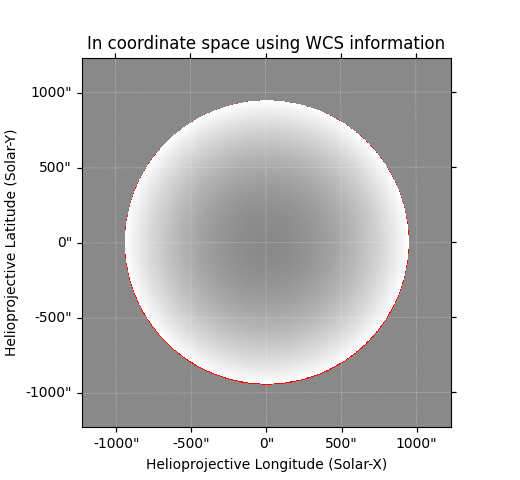
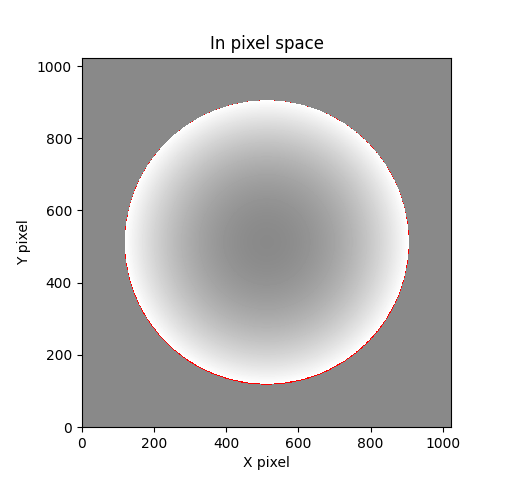
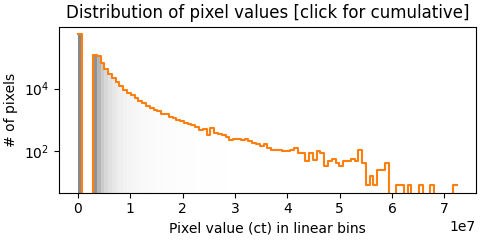
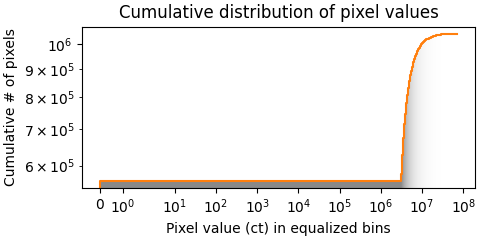

In [ ]:
areamap = create_correction_map(aia_map)
areamap

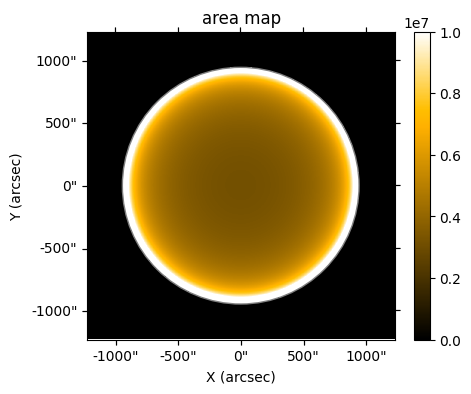

In [ ]:
#@title Plotting the area correction map [km2]
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(1, 1, 1,projection=areamap)
lin_norm = matplotlib.colors.Normalize(vmin=0, vmax=10**7)
im = areamap.plot(norm=lin_norm, title='area map')
areamap.draw_limb(color='gray')
plt.ylabel('Y (arcsec)')
plt.xlabel('X (arcsec)')
ax.coords.grid(False)
plt.colorbar(im,ax = ax, spacing='uniform')

fig.show()

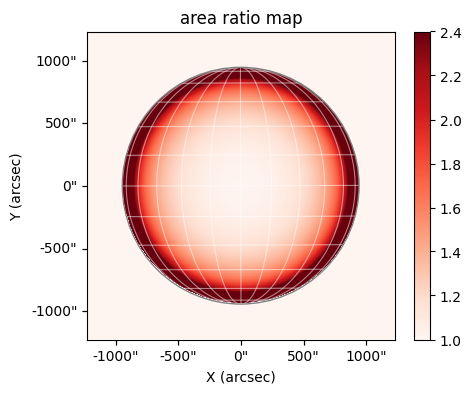

In [ ]:
#@title Visualize the ratio of corrected pixels areas to the average
#calculating the area of the center pixel for normalization

l = 695700 / aia_map.meta['rsun_obs'] * aia_map.meta['CDELT1'] #resolution km in pix
square_pixel = l*l #area of the square pixel

area = sunpy.map.Map(areamap.data/square_pixel, areamap.meta)
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(1, 1, 1,projection=area)

lin_norm = matplotlib.colors.Normalize(vmin=1, vmax=2.4)
im = area.plot(cmap='Reds',norm=lin_norm, title='area ratio map')
area.draw_limb(color='gray')
area.draw_grid()
plt.ylabel('Y (arcsec)')
plt.xlabel('X (arcsec)')
ax.coords.grid(False)

plt.colorbar(im,ax = ax, spacing='uniform')

fig.show()

In [ ]:
# save the area correction map
areamap.save('areamap.fits')